In [79]:
# Time series forecasting challenge 
# EDA and series decomposition (with training data)
# libs


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns



In [132]:
#Data
train_df = pd.read_csv("train.csv")
train_df.head()


,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [133]:
# Convert date col to datetime
train_df['date'] = pd.to_datetime(train_df['date'])


# Number of unique values in each column
num_unique_values = train_df.nunique()

# List of unique values in each column
unique_values_list = train_df.apply(lambda x: x.unique())

print("Number of unique values in each column:")
print(num_unique_values)

print("\nUnique values in each column:")
print(unique_values_list)

Number of unique values in each column:
id          136950
date          1826
country          5
store            3
product          5
num_sold      1028
dtype: int64

Unique values in each column:
id          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
date        [2017-01-01T00:00:00.000000000, 2017-01-02T00:...
country            [Argentina, Canada, Estonia, Japan, Spain]
store                 [Kaggle Learn, Kaggle Store, Kagglazon]
product     [Using LLMs to Improve Your Coding, Using LLMs...
num_sold    [63, 66, 9, 59, 49, 88, 98, 14, 83, 69, 340, 3...
dtype: object


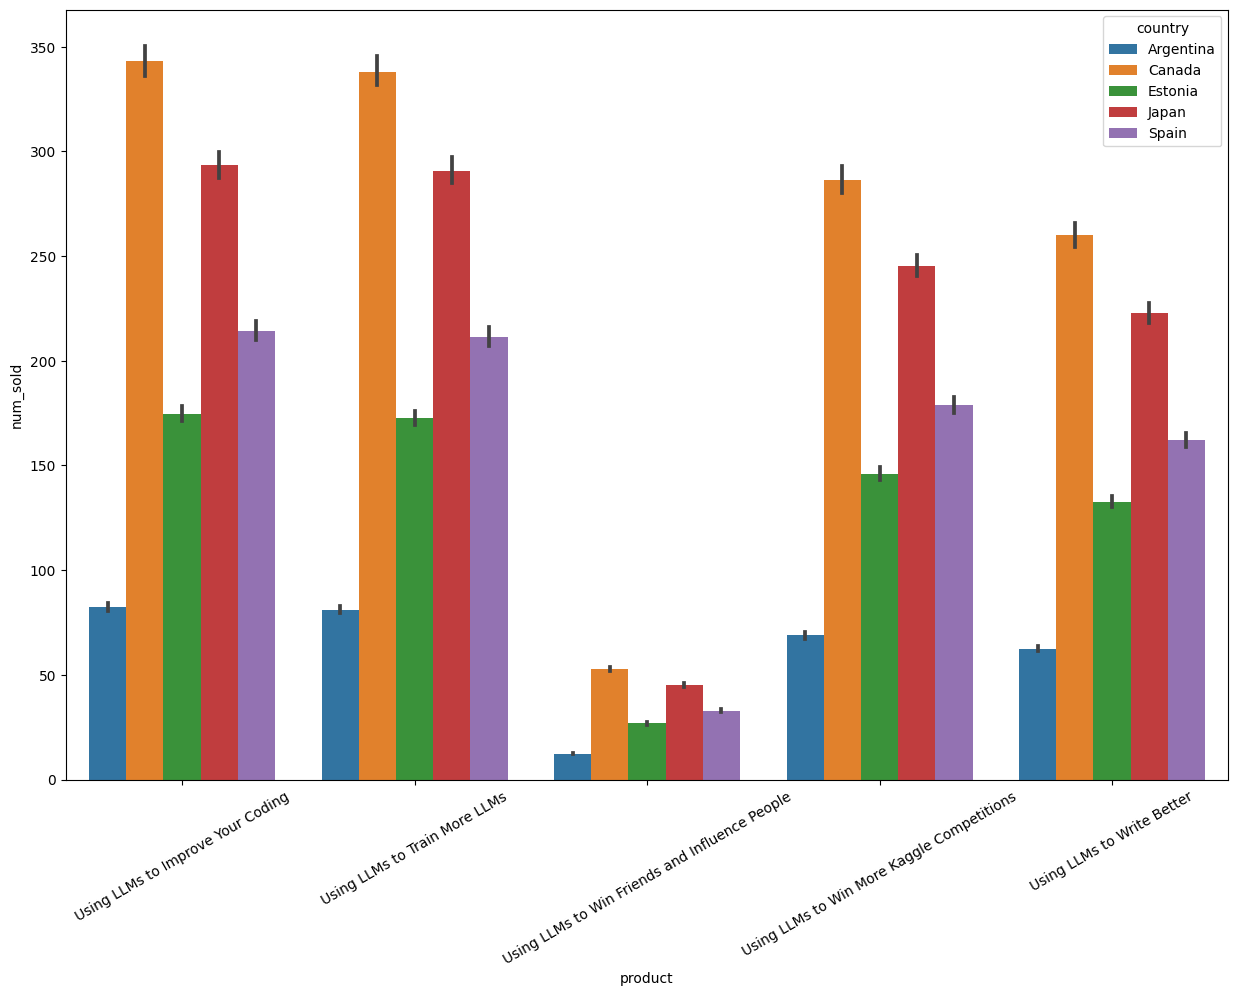

In [13]:
#plot
plt.figure(figsize = (15, 10))

ax = sns.barplot(data = train_df, x = 'product', y = 'num_sold', hue = 'country')
plt.xticks(rotation = 30);

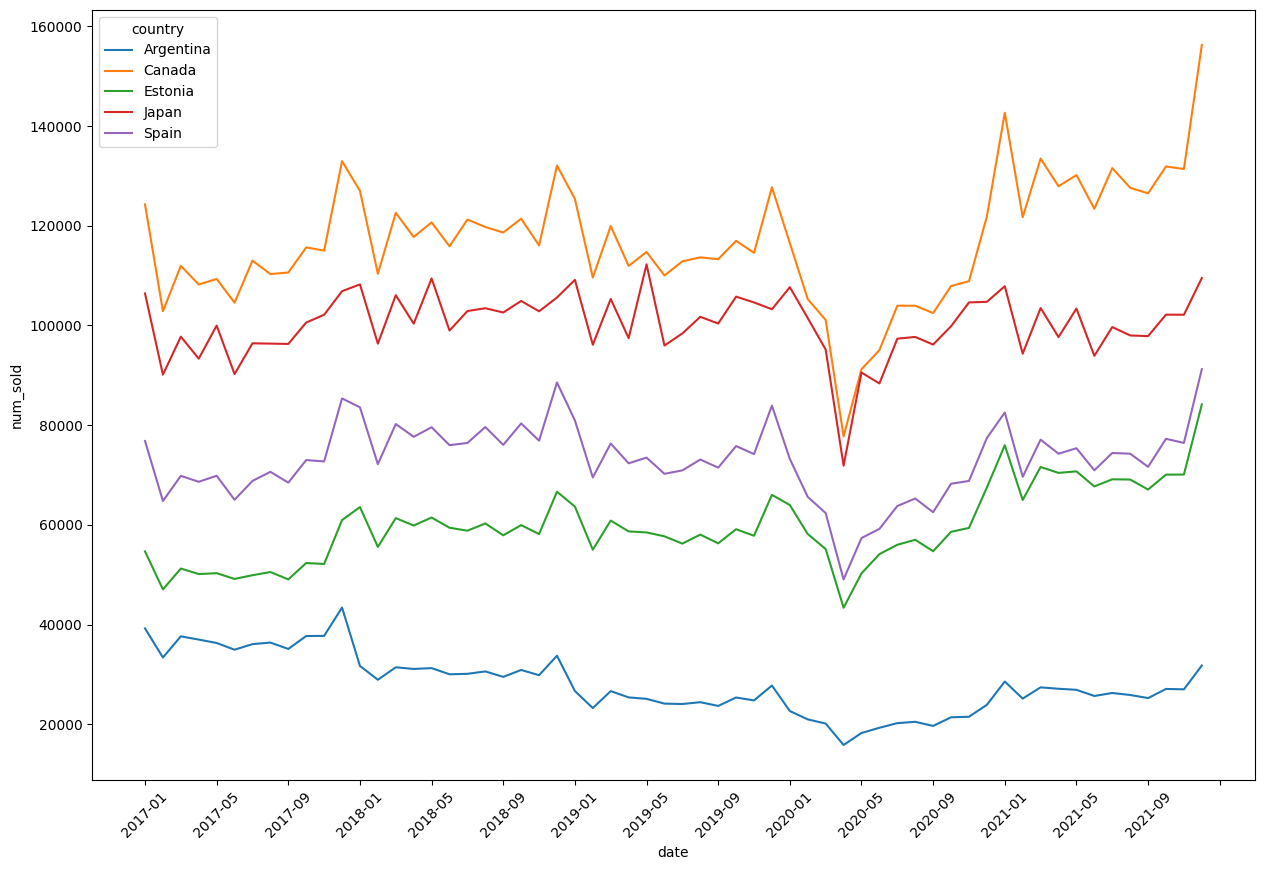

In [27]:
plt.figure(figsize = (15, 10))

ax = sns.lineplot(data = train_df.groupby([train_df.date.dt.strftime('%Y-%m'), train_df.country])['num_sold'].sum().reset_index(),
                  x = 'date',
                  y = 'num_sold',
                  hue ='country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

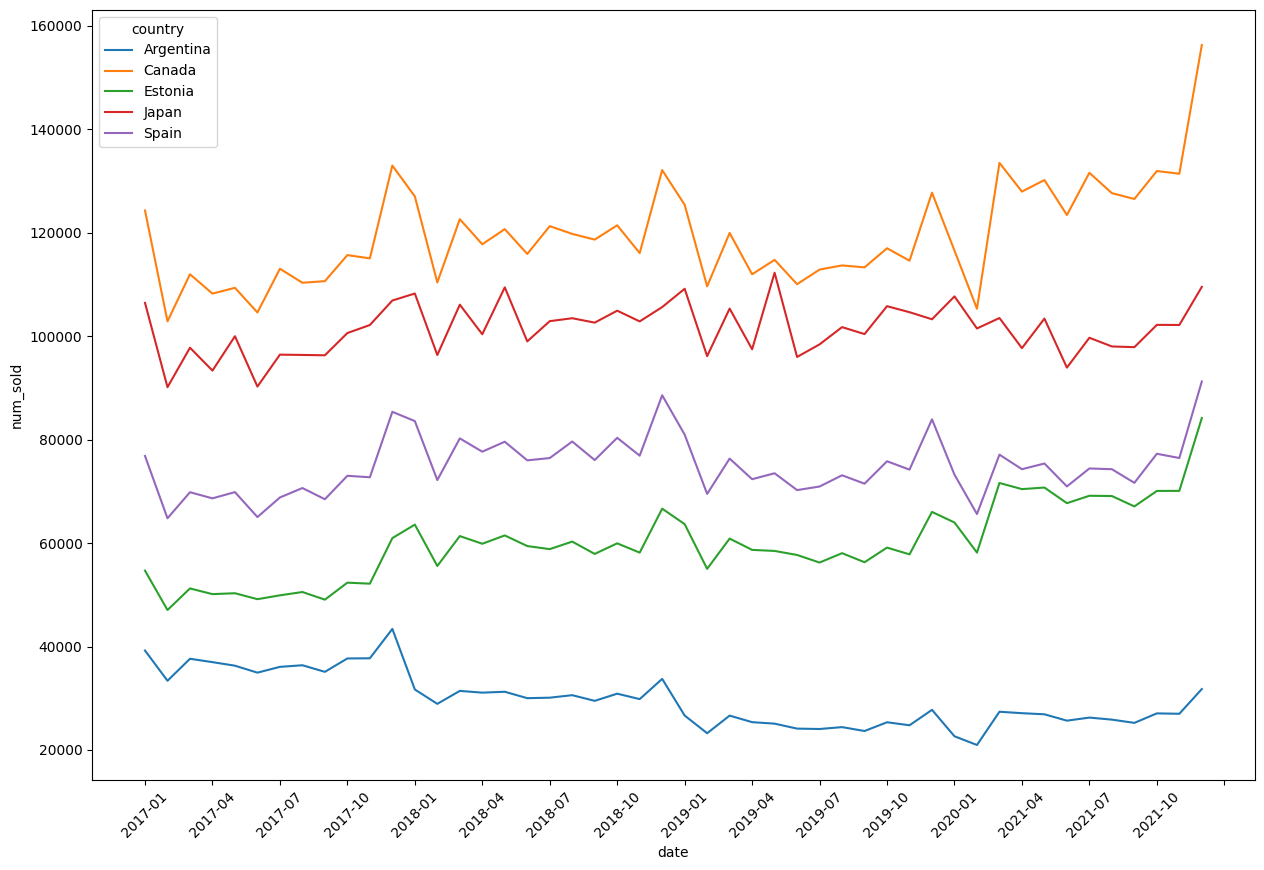

In [126]:
#Take Covid into account. Get rid of big out of charachter dip

covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-02-28')

# Filter out data during the COVID-19 pandemic sales boom
train_df = train_df[~((train_df['date'] >= covid_start_date) & (train_df['date'] <= covid_end_date))]

# Plot again

plt.figure(figsize = (15, 10))

ax = sns.lineplot(data = train_df.groupby([train_df.date.dt.strftime('%Y-%m'), train_df.country])['num_sold'].sum().reset_index(),
                  x = 'date',
                  y = 'num_sold',
                  hue ='country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);



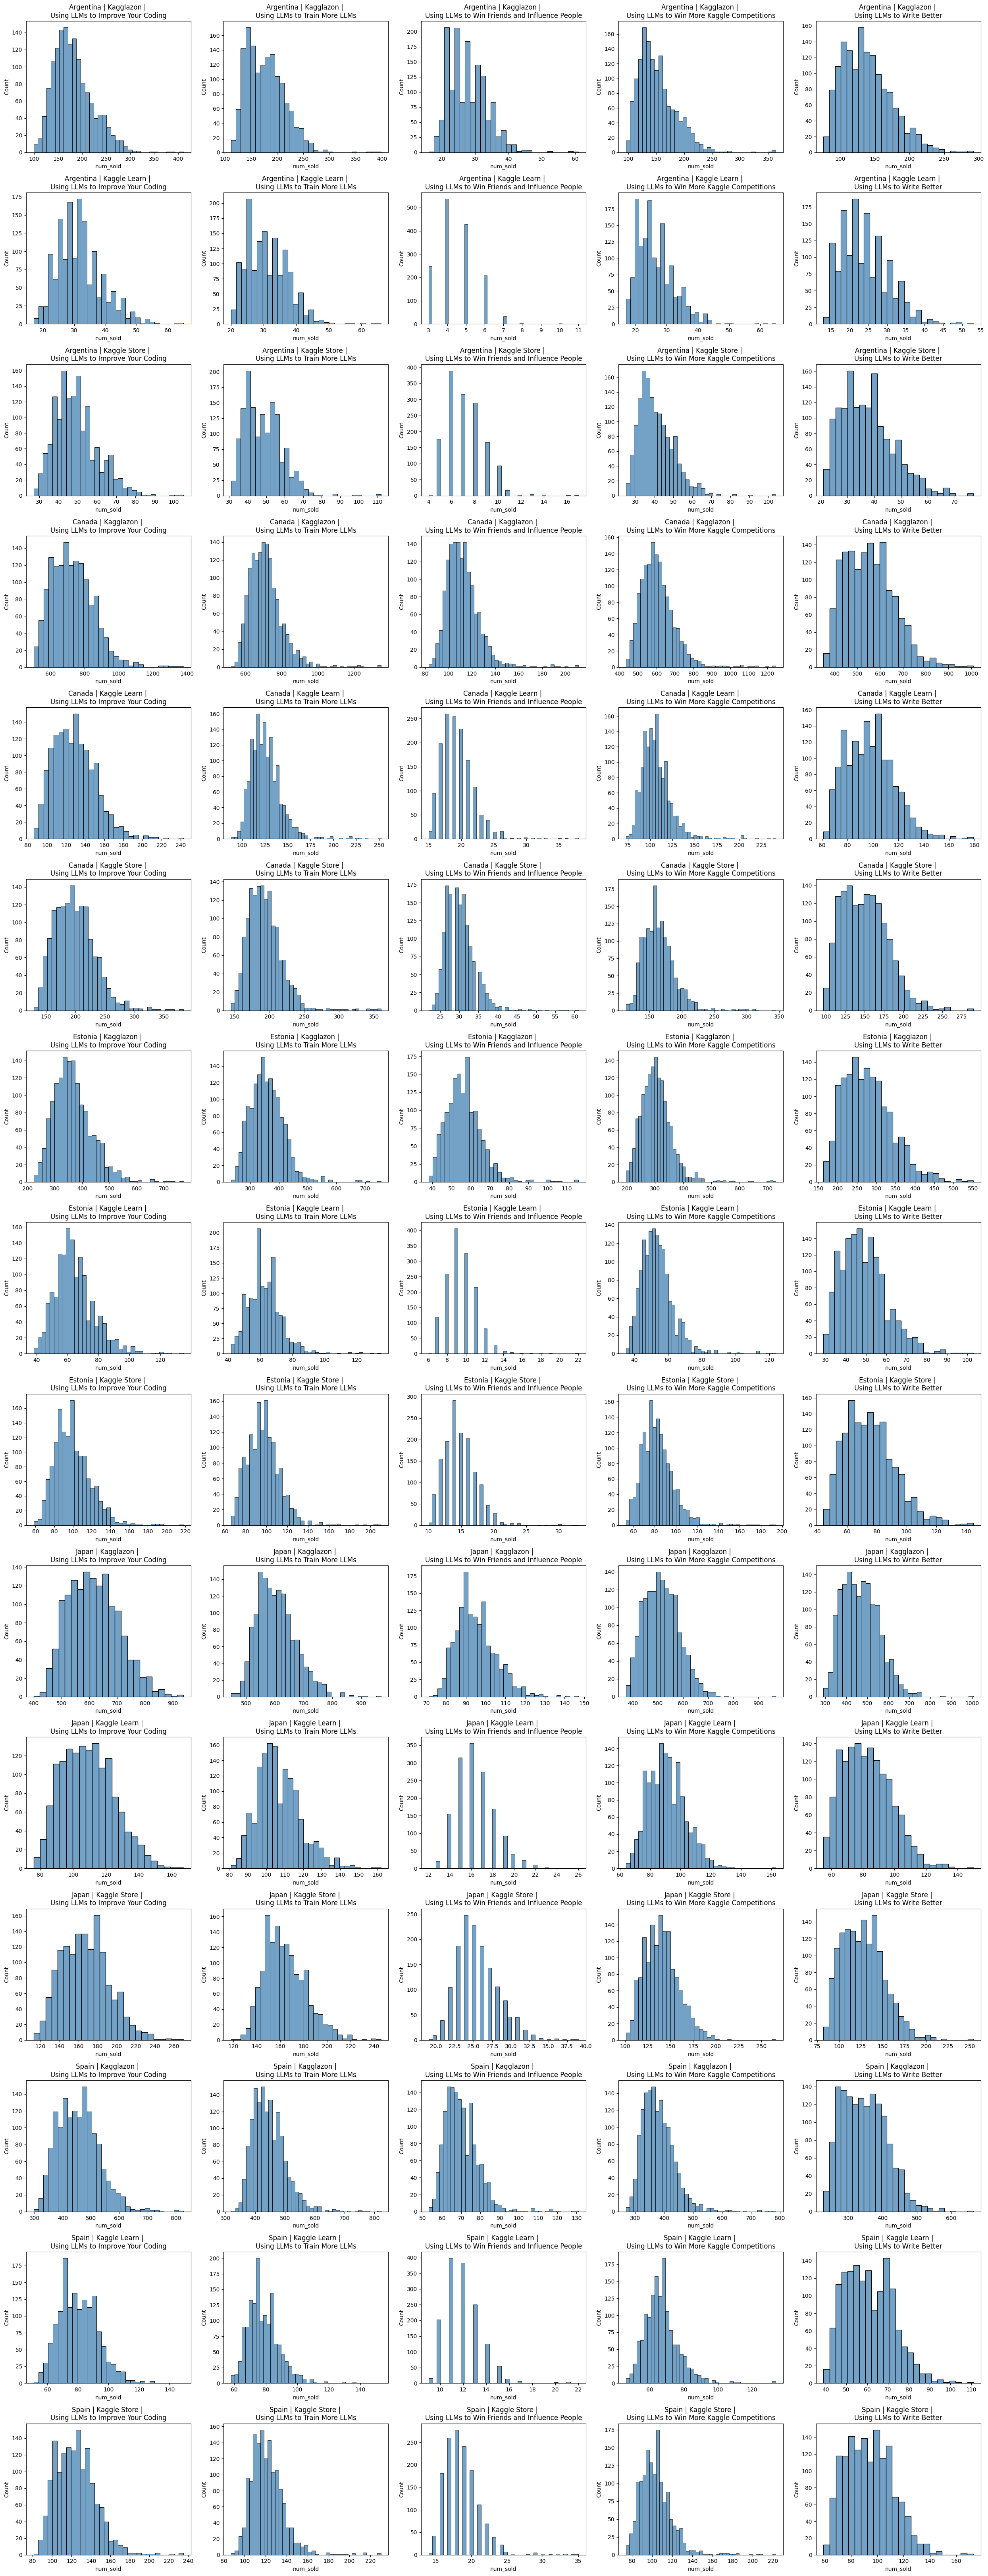

In [ ]:
# Find distributions of data 
# Right-skewed

fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()

for i, (combination, df) in enumerate(train_df.groupby(['country', 'store', 'product'])):
    sns.histplot(df.num_sold, ax = ax[i], color = 'steelblue')
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])

plt.tight_layout()

In [134]:
#Product mapping for Trend Decomp

prod_mapping = {'Using LLMs to Improve Your Coding': 1, 'Using LLMs to Train More LLMs': 2,
                'Using LLMs to Win Friends and Influence People': 3, 'Using LLMs to Write Better':4,
               'Using LLMs to Win More Kaggle Competitions':5}  # You can extend this mapping as needed

train_df['product'] = train_df['product'].map(prod_mapping)
train_df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,1,63
1,1,2017-01-01,Argentina,Kaggle Learn,2,66
2,2,2017-01-01,Argentina,Kaggle Learn,3,9
3,3,2017-01-01,Argentina,Kaggle Learn,5,59
4,4,2017-01-01,Argentina,Kaggle Learn,4,49


In [135]:
#Try addititve decomp

# train_df.set_index('date',inplace=True)
# # train_df.index.freq = 'M'  
# train_df.head()

In [162]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'num_sold' is of numeric data type
train_df['num_sold'] = pd.to_numeric(train_df['num_sold'])

# Set 'date' column as the DataFrame index
# train_df.set_index('date', inplace=True)

# Handle duplicate dates by aggregating the data (using mean as an example)
train_df = train_df.groupby(level=0).mean()

# Ensure the DataFrame has a daily frequency
daily_index = pd.date_range(start=train_df.index.min(), end=train_df.index.max(), freq='D')
train_df = train_df.reindex(daily_index)

# Fill any missing values with appropriate method, e.g., forward fill (ffill)
train_df['num_sold'].fillna(method='ffill', inplace=True)

# Now you can perform the seasonal decomposition
result = seasonal_decompose(train_df['num_sold'], model='additive')


In [142]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

2017-01-01           NaN
2017-01-02           NaN
2017-01-03           NaN
2017-01-04    205.626667
2017-01-05    195.198095
                 ...    
2021-12-27    235.211429
2021-12-28    246.449524
2021-12-29           NaN
2021-12-30           NaN
2021-12-31           NaN
Freq: D, Name: trend, Length: 1826, dtype: float64
2017-01-01    22.829262
2017-01-02    -8.625075
2017-01-03    -8.619265
2017-01-04    -8.793280
2017-01-05    -8.494562
                ...    
2021-12-27    -8.625075
2021-12-28    -8.619265
2021-12-29    -8.793280
2021-12-30    -8.494562
2021-12-31     2.732368
Freq: D, Name: seasonal, Length: 1826, dtype: float64
2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04   -3.286720
2017-01-05    1.069800
                ...   
2021-12-27   -3.599687
2021-12-28    8.929741
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Freq: D, Name: resid, Length: 1826, dtype: float64
2017-01-01    267.813333
2017-01-02    207.506667
20

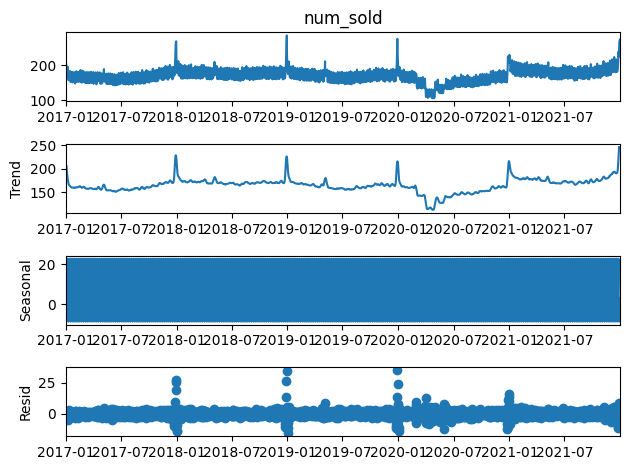

In [141]:
result.plot()
plt.show()

In [147]:
#Moving average De-trending

# Detrend the Data (Example using Moving Average Detrending)
window_size = 30  # Monthly Moving avg
moving_avg = train_df['num_sold'].rolling(window=window_size).mean()
detrended_sales = train_df['num_sold'] - moving_avg


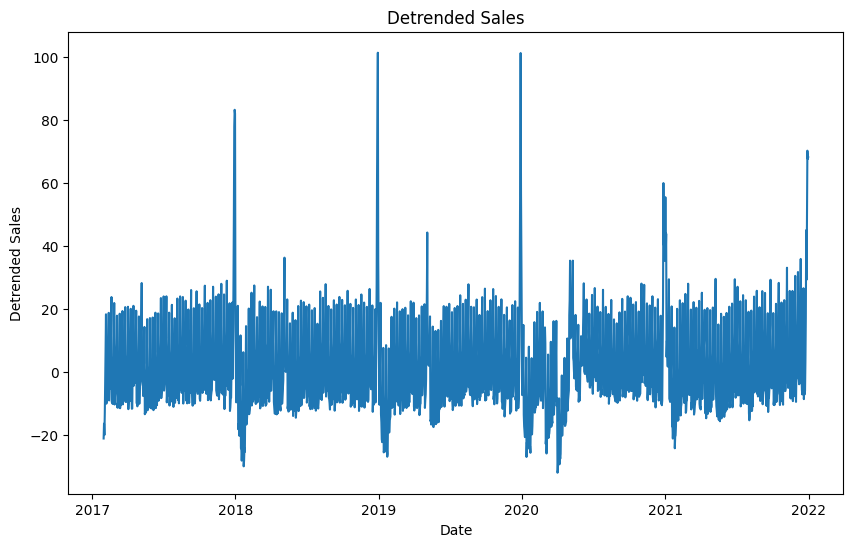

In [148]:
# Plot the detrended sales to visualize the detrended series
plt.figure(figsize=(10, 6))
plt.plot(detrended_sales)
plt.title('Detrended Sales')
plt.xlabel('Date')
plt.ylabel('Detrended Sales')
plt.show()

In [179]:
residuals = result.resid
residuals = pd.to_numeric(residuals)
residuals

2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04   -3.286720
2017-01-05    1.069800
                ...   
2021-12-27   -3.599687
2021-12-28    8.929741
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
Freq: D, Name: resid, Length: 1826, dtype: float64

In [188]:
# lots of missing values, so will try to interpolate residuals

# Access the residuals from seasonal_decompose and interpolate missing values
residuals_interpolated = result.resid.interpolate(method='linear')
residuals_interpolated = pd.to_numeric(residuals_interpolated, errors='coerce')
# residuals_interpolated

residuals_interpolated.index = pd.to_datetime(residuals_interpolated.index)
residuals_interpolated

2017-01-01         NaN
2017-01-02         NaN
2017-01-03         NaN
2017-01-04   -3.286720
2017-01-05    1.069800
                ...   
2021-12-27   -3.599687
2021-12-28    8.929741
2021-12-29    8.929741
2021-12-30    8.929741
2021-12-31    8.929741
Freq: D, Name: resid, Length: 1826, dtype: float64

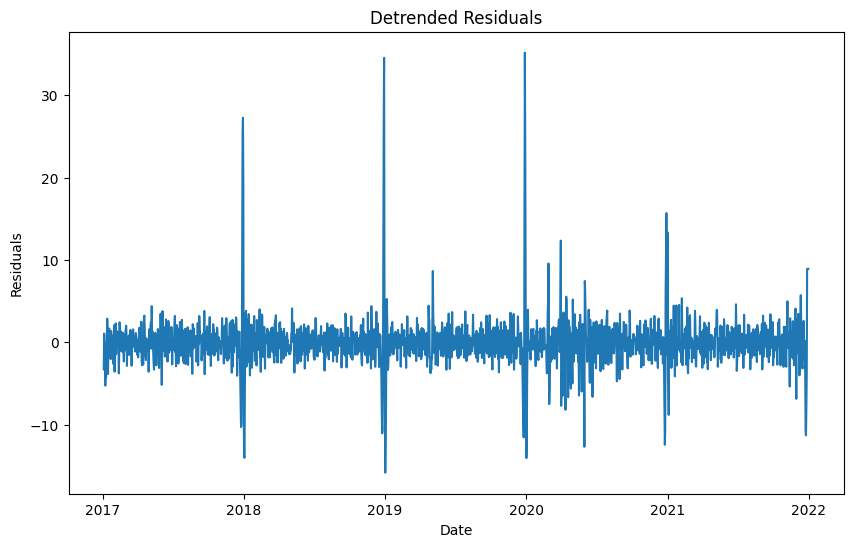

In [185]:
# Visual Inspection
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, residuals_interpolated)
plt.title('Detrended Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [199]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Need to test for autocorrelation before going in the direction of ARMA models

# Assuming you have already detrended the time series using seasonal_decompose
result = seasonal_decompose(train_df['num_sold'], model='additive')

# Access the residuals from seasonal_decompose and interpolate missing values
residuals = result.resid.interpolate()

# Convert the Series to a DataFrame before plotting
residuals_df = pd.DataFrame({'residuals': residuals})

# Check data type and convert to numeric if needed
residuals_df['residuals'] = pd.to_numeric(residuals_df['residuals'], errors='coerce')

# Check time index and convert to datetime if needed
residuals_df.index = pd.to_datetime(residuals_df.index)

# Drop any remaining NaNs after interpolation
residuals_df.dropna(inplace=True)





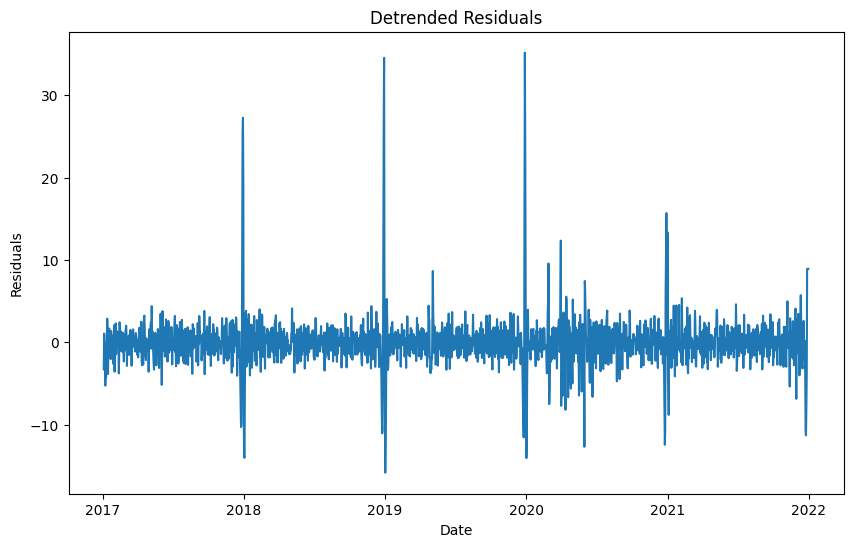

In [200]:
#Plots 

plt.figure(figsize=(10, 6))
plt.plot(residuals_df.index, residuals_df['residuals'])
plt.title('Detrended Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


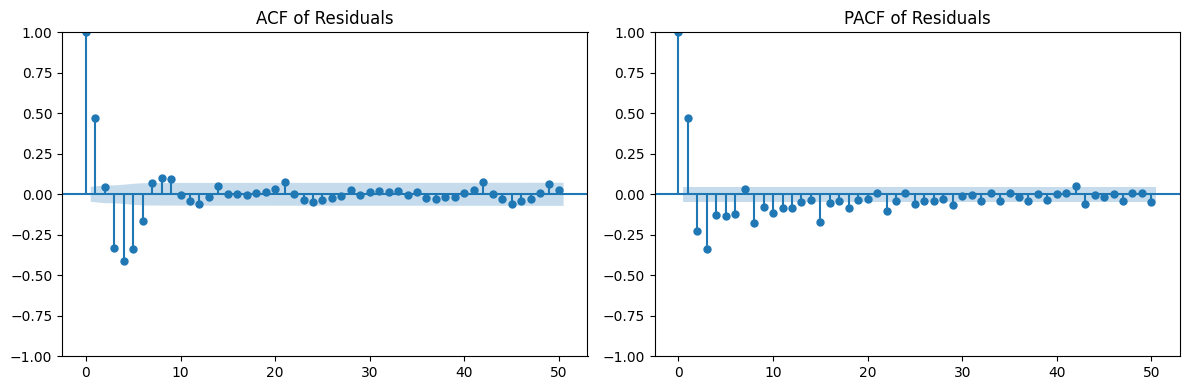

In [201]:
# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(residuals_df['residuals'], lags=50, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(122)
plot_pacf(residuals_df['residuals'], lags=50, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


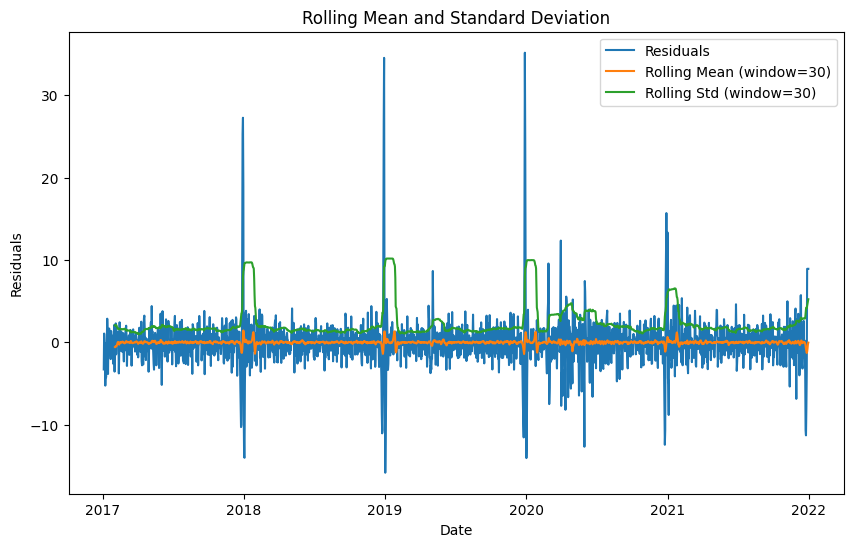

In [202]:
# Rolling Statistics
rolling_mean = residuals.rolling(window=30).mean()
rolling_std = residuals.rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.plot(rolling_mean, label='Rolling Mean (window=30)')
plt.plot(rolling_std, label='Rolling Std (window=30)')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [203]:
# Augmented Dickey-Fuller Test for Stationarity
result_adf = adfuller(residuals.dropna())
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value}')

#results point towards stationary data ... excellent news

ADF Statistic: -14.768697770431848
p-value: 2.3407092417196358e-27
Critical Values:
	1%: -3.4339942213257535
	5%: -2.8631497209507284
	10%: -2.567626963361616


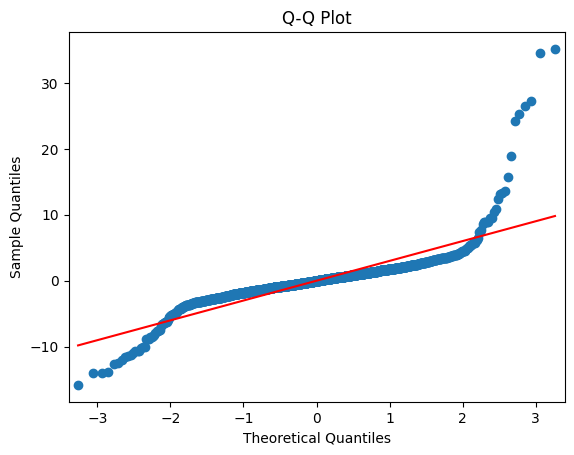

In [205]:
# Q-Q Plot for Normality
qqplot(residuals.dropna(), line='s')
plt.title('Q-Q Plot')
plt.show()



Ljung-Box Test Results:
        lb_stat      lb_pvalue
1    402.678294   1.438496e-89
2    405.952755   7.054713e-89
3    609.269154  9.861429e-132
4    919.865078  8.269392e-198
5   1125.098108  4.906955e-241
6   1176.062297  7.253788e-251
7   1184.989722  1.243712e-251
8   1203.871656  1.397195e-254
9   1221.149096  3.294404e-257
10  1221.156236  3.934558e-256


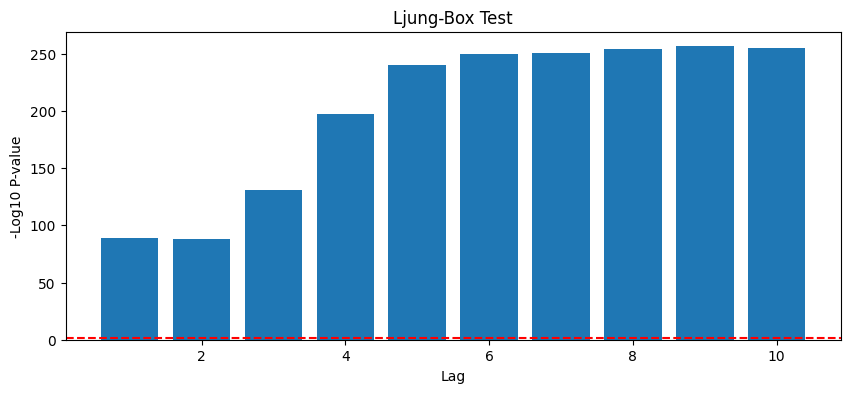

In [246]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

residuals.dropna(inplace=True)

results = acorr_ljungbox(residuals, lags=10)

print("Ljung-Box Test Results:")
print(results)

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(results['lb_pvalue']) + 1), -np.log10(results['lb_pvalue']))
plt.axhline(y=-np.log10(0.05), color='red', linestyle='dashed')
plt.title('Ljung-Box Test')
plt.xlabel('Lag')
plt.ylabel('-Log10 P-value')
plt.show()

#Significant autocorrelation detected


In [ ]:
# So we have a stationary, highly autocorrelated model implying no trend but highly seasonal
# Theoretical model selection is as follows:

# SARIMA can account for the seasonality in data, as well as any other autocorrelations. 
# It is essentially an extension of the ARIMA model that includes additional seasonal terms.

# Prophet (FB)

# TBATS (Trigonometric seasonality, Box-Cox, ARIMA, Trend and Seasonal)

# Finally, Temporal Fusion Transformer (Not enough computing power.) Save for future iterations
